In [36]:
# Load libraries
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats
import statsmodels.api as sm

In [2]:
# Open yvr_listing_data.csv in the data folder
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data.csv'))

# Print columns
# print(listings_df.columns)

# Select columns that are completly textual description or apparently non-related to legality(including coordinates).

excluded_columns = ['listing_url','scrape_id', 'last_scraped', 'source', 
                       'name','description', 'neighborhood_overview', 'picture_url', 
                       'host_id', 'host_url', 'host_name', 'host_since', 
                       'host_location', 'host_about', 'host_thumbnail_url', 
                       'host_picture_url', 'latitude', 'longitude', 'calendar_updated', 
                       'calendar_last_scraped', 'amenities', 'bathrooms_text']

remained_columns = [col for col in listings_df if col not in excluded_columns]
remained_columns = list(set(remained_columns))

# Delete all textual description columns 

listings_df = listings_df[remained_columns]



In [3]:
%%capture --no-stdout
"""
Create a new column titled "legal_listing" that contains the boolean describing whether or not the listing has a valid license.
The column is True if the listing has a valid license or does not require one and False if the listing does not have a valid license.
To compute the value of the column, we use the following logic:

If the listing has a number in the "license" column with the regex pattern of r'.*?(\d{2}[-\s]?\d{6}).*?' 
OR the listing has a number in the "minimum_nights" column with a value equal to or greater than 30,
THEN the "legal_listing" is True. ELSE the "valid_license" is False.

Note:
The regex pattern r'.*?(\d{2}[-\s]?\d{6}).*?' is used to find a number with 2 digits, followed by a dash or space, 
followed by 6 digits. The number can be surrounded by any number of characters. 
TODO: Verify this is the correct pattern for the license numbers and find any other ways of verifying legitimate license numbers.
"""

###Just found there are some values like 'dd-ddd-ddd', so I changed regex pattern for better compatibility
#regex_pattern = re.compile(r'.*?(\d{2}[-\s]?\d{6}).*?')
regex_pattern = re.compile(r'.*?(\d{2}[-\s]?\d{3}[-\s]?\d{3}).*?')

# Create the valid_license column using the logic described above
listings_df['legal_listing'] = listings_df['license'].str.contains(regex_pattern) | (listings_df['minimum_nights'] >= 30)

# Create new dataframe storing values after normalization or preprocessing
listings_df_cleaned = pd.DataFrame()
listings_df_cleaned['id'] = listings_df['id']
listings_df_cleaned['legal_listing'] = listings_df['legal_listing']

# Print only the columns we are interested in
#print(listings_df[['id', 'license', 'minimum_nights', 'legal_listing']])

# Print count of valid and invalid licenses
#print(listings_df['legal_listing'].value_counts())

Hey guys, just came up with a new assumption: As our main goal is to construct a regression model and predict a new-coming property's legality, should we neglect all of those 'post-occupancy evaluation'  fields just like 'review_score' or 'host_response_time'? Because all of those information was collected after some renter's experience, while what we are trying to do is to provide more useful information for renters before the renting contract?

And I have done some preliminary filtering and division among all columns.

In [4]:
print(listings_df.columns)

Index(['maximum_nights_avg_ntm', 'availability_30', 'host_neighbourhood',
       'license', 'instant_bookable', 'host_listings_count', 'minimum_nights',
       'number_of_reviews', 'host_is_superhost', 'host_identity_verified',
       'availability_90', 'neighbourhood_group_cleansed',
       'calculated_host_listings_count_entire_homes', 'host_response_rate',
       'maximum_minimum_nights', 'id', 'review_scores_location',
       'review_scores_value', 'host_total_listings_count',
       'calculated_host_listings_count_shared_rooms',
       'review_scores_communication', 'bedrooms', 'availability_60',
       'host_response_time', 'beds', 'review_scores_accuracy',
       'reviews_per_month', 'review_scores_rating', 'review_scores_checkin',
       'number_of_reviews_ltm', 'property_type', 'accommodates',
       'minimum_maximum_nights', 'maximum_maximum_nights', 'room_type',
       'host_verifications', 'calculated_host_listings_count_private_rooms',
       'host_acceptance_rate', 'neigh

**Now we should divide all of above columns into various groups.**

First, there are some fields representing same things, or have been through some basic converting or cleaning, such as:

1.**host_info** = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified']



2.**location** = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']


In [38]:
## After comparing three columns, 'neighbourhood_cleansed' should perfectly be as a categorical variable and represent other columns
#     print(listings_df.sample(n=20)[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']])

# Check all the unique values and its frequency in column 'neighbourhood_cleansed'
listings_df['neighbourhood_cleansed'].nunique()
# There are 23 categories in column 'neighbourhood_cleansed'
listings_df['neighbourhood_cleansed'].value_counts()

# Problem is that how should we use this variable through one-hot coding? (too many variables, means 22 columns for coding these categories)

neighbourhood_cleansed
Downtown                    1720
West End                     512
Kitsilano                    500
Mount Pleasant               437
Kensington-Cedar Cottage     427
Downtown Eastside            350
Riley Park                   324
Grandview-Woodland           289
Hastings-Sunrise             276
Renfrew-Collingwood          248
Dunbar Southlands            222
Marpole                      188
Fairview                     177
Sunset                       159
Victoria-Fraserview          142
Arbutus Ridge                124
West Point Grey              116
Oakridge                     110
Kerrisdale                    90
Killarney                     88
Shaughnessy                   80
South Cambie                  77
Strathcona                    39
Name: count, dtype: int64

3.**review_info** = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review' 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']


4.**Categories** = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds']

53
4
6695
0


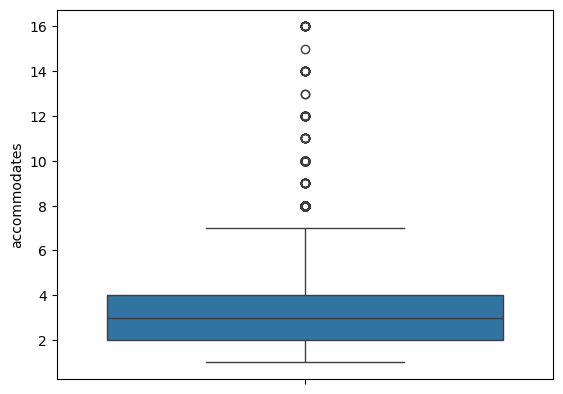

In [15]:
########### property_type
# Check all the unique values and its frequency in column 'property_type'
print(listings_df['property_type'].nunique())
# There are 23 categories in column 'property_type'
#print(listings_df['property_type'].value_counts())

########## room_type
# Check all the unique values and its frequency in column 'room_type'
print(listings_df['room_type'].nunique())
# There are 23 categories in column 'room_type'
#print(listings_df['room_type'].value_counts())

########## bathrooms
print(listings_df['bathrooms'].isna().sum())
# Column 'bathrooms' is mostly NAs, therefore Excluded

########## accommodates, after checking the outliers, I don't think they should be removed due to our statistical context.
print(listings_df['accommodates'].isna().sum())

# Checking outliers, most of them are in range [0,8] and the largest is 16.
"""
sns.boxplot(listings_df['accommodates'])
plt.show()
Q1 = listings_df['accommodates'].quantile(0.25)
Q3 = listings_df['accommodates'].quantile(0.75)
IQR = Q3 - Q1
outliers = listings_df[(listings_df['accommodates'] < Q1 - 1.5*IQR) | (listings_df['accommodates'] > Q3 + 1.5*IQR)]
"""


5.**Availability** = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'instant_bookable']

All columns above have the data type of **'integer'** or **'numeric'** except *'has_availability'* for *Boolean*.

And All above are about the same topic. Therefore I suggest use the **VIF** to test their **multicollinearity** after ***normalizing these columns***.

In [69]:
# Check the correlation between 'has_availability' and 'legal_listing'

# construct the contingency table
contingency_table = pd.crosstab(listings_df['legal_listing'], listings_df['has_availability'])

# operate the chi-square test
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

# Print the chi-square test results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

# So convert boolean type to 0-1 values



Chi-square statistic: 33.26441945728767
P-value: 8.044105931081192e-09
Degrees of Freedom: 1


In [71]:
# Check the correlation between 'instant_bookable' and 'legal_listing'

# construct the contingency table
contingency_table = pd.crosstab(listings_df['legal_listing'], listings_df['instant_bookable'])

# operate the chi-square test
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

# Print the chi-square test results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

# I am considering whether to abandon this column as the p-value is 0.049

Chi-square statistic: 3.860069172516976
P-value: 0.04944828966682418
Degrees of Freedom: 1


0
0
0
0


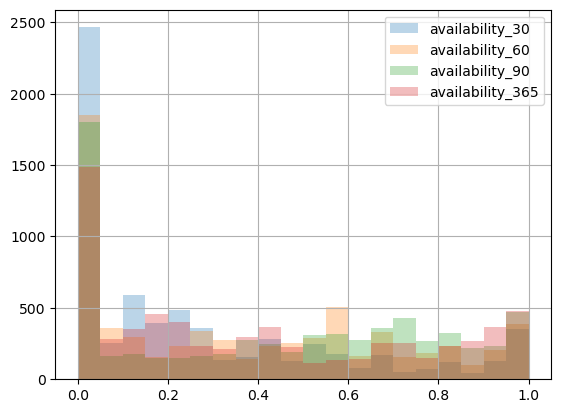

In [66]:
# Check the NA values in columns
print(listings_df['availability_30'].isna().sum())
print(listings_df['availability_60'].isna().sum())
print(listings_df['availability_90'].isna().sum())
print(listings_df['availability_365'].isna().sum())
(listings_df['availability_30']/30).hist(bins=20, alpha=0.3,label='availability_30')
(listings_df['availability_60']/60).hist(bins=20, alpha=0.3,label='availability_60')
(listings_df['availability_90']/90).hist(bins=20, alpha=0.3,label='availability_90')
(listings_df['availability_365']/365).hist(bins=20, alpha=0.3,label='availability_365')
plt.legend()
plt.show()


In [58]:
# Fit the Point-Biserial Correlation model for 'availability_30'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/30, listings_df['availability_30'])
print(correlation)
print(p_value)

-0.052928564161434974
1.4709020756292807e-05


In [57]:
# Fit the Point-Biserial Correlation model for 'availability_60'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/60, listings_df['availability_60'])
print(correlation)
print(p_value)

-0.029946080873341732
0.014270966405721817


In [56]:
# Fit the Point-Biserial Correlation model for 'availability_90'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/90, listings_df['availability_90'])
print(correlation)
print(p_value)

-0.028117638563610835
0.02140892074529158


In [55]:
# Fit the Point-Biserial Correlation model for 'availability_365'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/365, listings_df['availability_365'])
print(correlation)
print(p_value)

-0.17020479061535984
1.0728575606541276e-44


6.**PRICE** = ['price']

In [19]:
# 6.PRICE 

# Convert price to a float variable (already done before, so I put a '#' ahead)
#listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Concat PRICE column into cleaned_listing
listings_df_cleaned['price'] = listings_df['price']

# Normalization of prices, I suggest the Z-score Normalization because 
# the lower price and higher price could have opposite indication about the legality.
scaler = StandardScaler()
listings_df_cleaned['price_normed'] = scaler.fit_transform(listings_df[['price']])

7.**hosts' asset** = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',]

In [11]:
# Save the dataframe to a new csv file
#listings_df.to_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'), index=False)